## Imports & Settings


In [191]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq
import warnings

# Formatter for scientific notation on axes
sci_formatter = mticker.ScalarFormatter(useMathText=True)
sci_formatter.set_powerlimits((0,0))

fps = 60

## Core Analysis Functions

In [192]:
def pendulum_velocity(theta, k, r, phi):
    # physical model: v = sqrt(2*(r-1 + cos(theta-phi)) * (g/L))
    arg = 2 * (r - 1 + np.cos(theta - phi))
    return np.sqrt(np.maximum(0, k * arg))

def _fit_popt(bin_centers, median_velocity):
    valid = ~np.isnan(median_velocity) & (median_velocity > 1e-9)
    if np.sum(valid) < 3:
        print("Warning: Not enough valid data points (<3) to perform fit.")
        return [0.1, 1, 0]
    try:
        phi_guess = bin_centers[valid][np.argmax(median_velocity[valid])] if np.any(valid) else 0
        p0 = [
            np.nanmax(median_velocity**2)/4 if np.any(valid) else 0.1,
            1,
            phi_guess % (2*np.pi)
        ]
        p0[:2] = [max(1e-9, p) for p in p0[:2]]
        popt, _ = curve_fit(
            pendulum_velocity,
            bin_centers[valid],
            median_velocity[valid],
            p0=p0,
            bounds=([0,0,-np.pi],[np.inf,np.inf,3*np.pi]),
            maxfev=8000
        )
        popt[2] %= (2*np.pi)
    except Exception as e:
        print(f"Warning: Curve fit failed: {e}")
        popt = [0.1, 1, 0]
    return popt

def bin_and_fit(angle_forv, angle_v, angle_bins):
    med, p95, err, binned = [], [], [], []
    centers = (angle_bins[:-1] + angle_bins[1:]) / 2
    bw = angle_bins[1] - angle_bins[0]
    for i in range(len(centers)):
        mask = (angle_forv>=angle_bins[i])&(angle_forv<angle_bins[i+1])
        vals = angle_v[mask]; vals = vals[np.isfinite(vals)]
        if len(vals):
            med.append(np.median(vals))
            p95.append(np.percentile(vals,95))
            q75,q25 = np.percentile(vals,[75,25])
            iqr = q75-q25
            std = iqr/1.349
            err.append(1.253*std/np.sqrt(len(vals)) if len(vals)>1 else 0)
            binned.append(vals)
        else:
            med.append(np.nan); p95.append(np.nan); err.append(np.nan); binned.append(np.array([]))

    popt = _fit_popt(centers, np.array(med))
    return np.array(med), np.array(p95), np.array(err), popt, centers, bw, binned

def calculate_angles(frames, x1, y1, x2, y2, c1, c2):
    a1 = np.arctan2(y1-c1[1], x1-c1[0])
    a2 = np.arctan2(y2-c2[1], x2-c2[0])
    return a1, a2

def calculate_velocities(frames, angles1, angles2):
    # subsample every 6th frame
    t = frames[::6].astype(float)
    if len(t)<2:
        return np.array([]),np.array([]),np.array([]),np.array([])
    φ1,φ2 = np.unwrap(angles1[::6]), np.unwrap(angles2[::6])
    dt = np.diff(t); dt[dt<=1e-9] = np.nan
    v1 = np.abs(np.diff(φ1)/dt); v2 = np.abs(np.diff(φ2)/dt)
    ph1,ph2 = φ1[:-1], φ2[:-1]
    def clip_outliers(d):
        finite = d[np.isfinite(d)]
        if len(finite)<4: return d
        q1,q3 = np.percentile(finite,[25,75]); iqr=q3-q1
        lb,ub = q1-1.5*iqr, q3+1.5*iqr
        return np.where((d<lb)|(d>ub), np.nan, d)
    v1f, v2f = clip_outliers(v1), clip_outliers(v2)
    m1, m2 = ~np.isnan(v1f), ~np.isnan(v2f)
    return v1f[m1], v2f[m2], ph1[m1], ph2[m2]


## Load Data & Compute Fits

In [207]:
folder = R"C:\Users\avsha\Documents\GitHub\Ants\container\Analyzed Data\mega file 2"
#folder = R"C:\Users\avsha\Documents\GitHub\Ants\container\Analyzed Data\18.9.24\video 03pys"
coords = pd.read_csv(os.path.join(folder,'coordinates.csv'))
with open(os.path.join(folder,'metadata.json')) as f:
    meta = json.load(f)

frames = coords.iloc[:,0].values
x1,y1,x2,y2 = [coords.iloc[:,i].values for i in range(1,5)]
c1, c2 = meta['obj1_pivot'], meta['obj2_pivot']

angles1, angles2 = calculate_angles(frames, x1, y1, x2, y2, c1, c2)
v1, v2, ph1, ph2 = calculate_velocities(frames, angles1, angles2)

bins = np.linspace(0,2*np.pi,17)
b1 = bin_and_fit(ph1 % (2*np.pi), v1, bins)
b2 = bin_and_fit(ph2 % (2*np.pi), v2, bins)

# unpack for plotting
med1,p95_1,_,popt1,cent1,bw1,data1 = b1
med2,p95_2,_,popt2,cent2,bw2,data2 = b2
xfit = np.linspace(0,2*np.pi,500)
yfit1 = pendulum_velocity(xfit,*popt1)
yfit2 = pendulum_velocity(xfit,*popt2)


## Phase Space

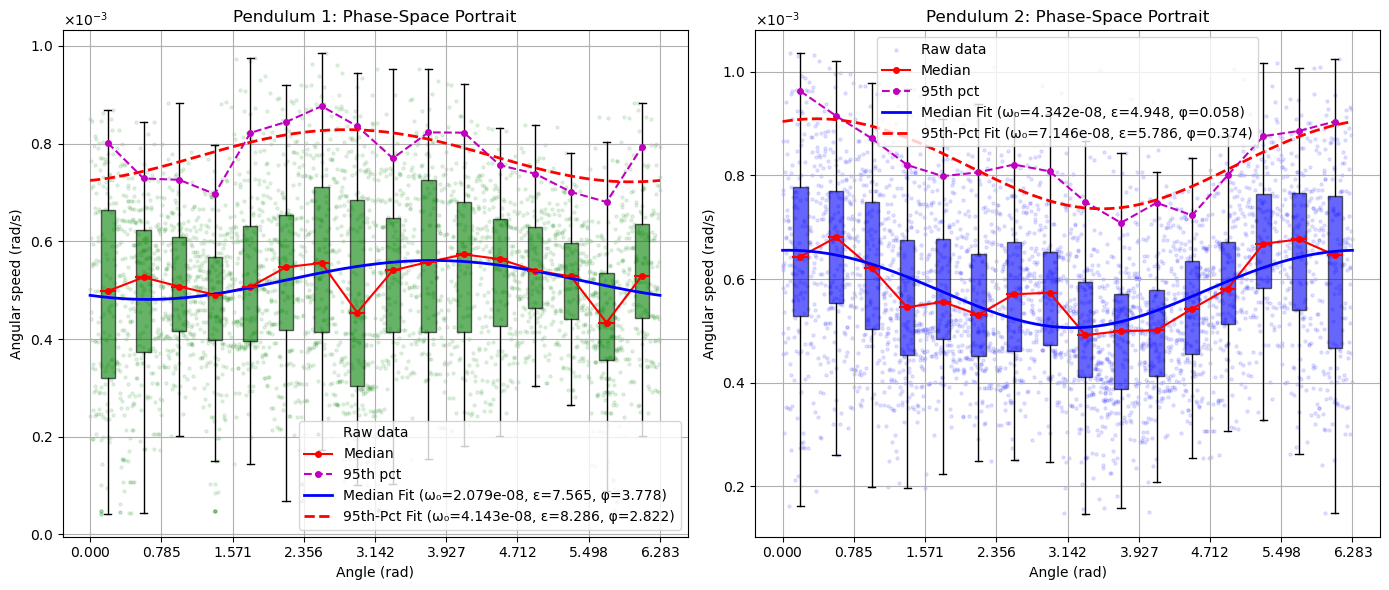

In [208]:
# Cell 4 (updated): Phase-Space Plots with Median & 95th-Pct Fits

# first compute the extra fits for the 95th pct data
popt95_1 = _fit_popt(cent1, p95_1)
popt95_2 = _fit_popt(cent2, p95_2)
yfit95_1 = pendulum_velocity(xfit, *popt95_1)
yfit95_2 = pendulum_velocity(xfit, *popt95_2)

fig_ps, axs_ps = plt.subplots(1, 2, figsize=(14, 6))
for ax, (ph, v, bdata, cent, bw, med, p95, 
        ymed_fit, popt_med, y95_fit, popt95, color, title) in zip(
    axs_ps.flatten(),
    [
      (ph1 % (2*np.pi), v1, data1, cent1, bw1, med1, p95_1,
       yfit1, popt1, yfit95_1, popt95_1, 'green', 'Pendulum 1'),
      (ph2 % (2*np.pi), v2, data2, cent2, bw2, med2, p95_2,
       yfit2, popt2, yfit95_2, popt95_2, 'blue',  'Pendulum 2'),
    ]
):
    # raw data
    ax.scatter(ph, v, alpha=0.1, color=color, s=5, label='Raw data')

    # binned boxplots
    valid = [d for d in bdata if len(d)>0]
    pos   = cent[[len(d)>0 for d in bdata]]
    if valid:
        ax.boxplot(
            valid, positions=pos, widths=bw*0.4,
            patch_artist=True, showfliers=False,
            boxprops=dict(facecolor=color, alpha=0.6),
            medianprops=dict(color='red', linewidth=1.5)
        )

    # medians & 95th pct markers
    ax.plot(cent[~np.isnan(med)], med[~np.isnan(med)],
            'ro-', markersize=4, label='Median')
    ax.plot(cent[~np.isnan(p95)], p95[~np.isnan(p95)],
            'mo--', markersize=4, label='95th pct')

    # fits
    ax.plot(xfit, ymed_fit, 'b-', lw=2,
            label=f'Median Fit (ω₀={popt_med[0]:.3e}, ε={popt_med[1]:.3f}, φ={popt_med[2]:.3f})')
    ax.plot(xfit, y95_fit, 'r--', lw=2,
            label=f'95th-Pct Fit (ω₀={popt95[0]:.3e}, ε={popt95[1]:.3f}, φ={popt95[2]:.3f})')

    # labels & formatting
    ax.set_xticks(np.linspace(0, 2*np.pi, 9))
    ax.set_xlabel('Angle (rad)')
    ax.set_ylabel('Angular speed (rad/s)')
    ax.set_title(f'{title}: Phase-Space Portrait')
    ax.legend(); ax.grid(True)
    ax.xaxis.set_major_formatter(sci_formatter)
    ax.yaxis.set_major_formatter(sci_formatter)

fig_ps.tight_layout()
plt.show()


## Angle vs Time (in minutes)

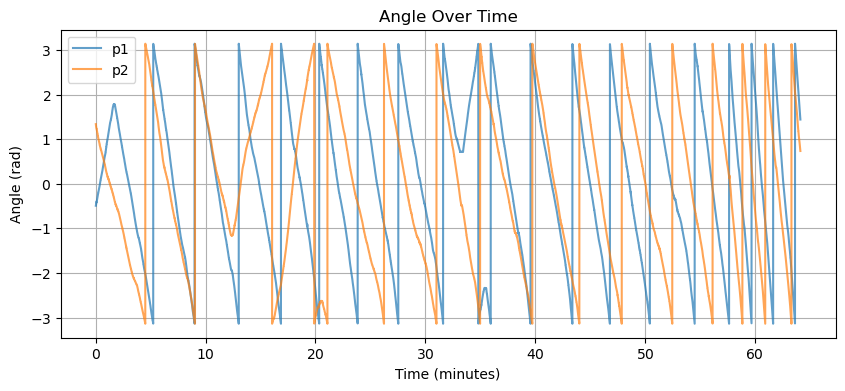

In [195]:
# convert frame index → seconds → minutes
time_min = frames / fps / 60  

plt.figure(figsize=(10, 4))
plt.plot(time_min, angles1, label='p1', alpha=0.7)
plt.plot(time_min, angles2, label='p2', alpha=0.7)

plt.title('Angle Over Time')
plt.xlabel('Time (minutes)')
plt.ylabel('Angle (rad)')
plt.legend(); plt.grid(True)

# keep scientific formatting if you like
ax = plt.gca()
ax.xaxis.set_major_formatter(sci_formatter)
ax.yaxis.set_major_formatter(sci_formatter)

plt.show()



## Speed Distribution

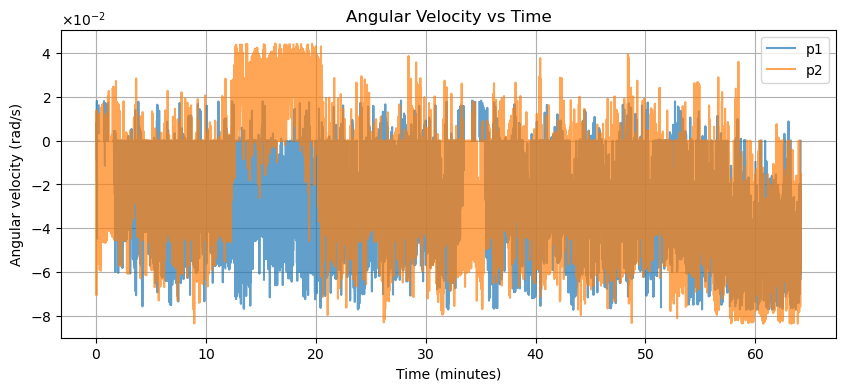

In [196]:
# Cell X: Angular Velocity vs Time (unwrap + outlier removal)

# 1) Time arrays
time_s   = frames / fps            # frames → seconds
time_min = time_s / 60             # seconds → minutes

# 2) Unwrap angles and compute finite‐difference velocities
phi1 = np.unwrap(angles1)
phi2 = np.unwrap(angles2)

dphi1 = np.diff(phi1)              # Δangle (rad)
dphi2 = np.diff(phi2)
dt     = np.diff(time_s)           # Δtime (s)
dt[dt <= 1e-9] = np.nan            # avoid divide-by-zero

omega1 = dphi1 / dt                # rad/s
omega2 = dphi2 / dt

# 3) Outlier removal via 1.5·IQR rule
def remove_outliers(v):
    v = np.array(v, copy=True)
    finite = v[np.isfinite(v)]
    if len(finite) < 4:
        return v
    q1, q3 = np.percentile(finite, [25, 75])
    iqr    = q3 - q1
    lb, ub = q1 - 1.5*iqr, q3 + 1.5*iqr
    # set extremes to NaN
    return np.where((v < lb) | (v > ub), np.nan, v)

omega1_clean = remove_outliers(omega1)
omega2_clean = remove_outliers(omega2)

# 4) Plot
plt.figure(figsize=(10, 4))
plt.plot(time_min[:-1], omega1_clean, label='p1', alpha=0.7)
plt.plot(time_min[:-1], omega2_clean, label='p2', alpha=0.7)
plt.title('Angular Velocity vs Time')
plt.xlabel('Time (minutes)')
plt.ylabel('Angular velocity (rad/s)')
plt.legend(); plt.grid(True)

ax = plt.gca()
ax.xaxis.set_major_formatter(sci_formatter)
ax.yaxis.set_major_formatter(sci_formatter)

plt.show()


## FFT Analysis

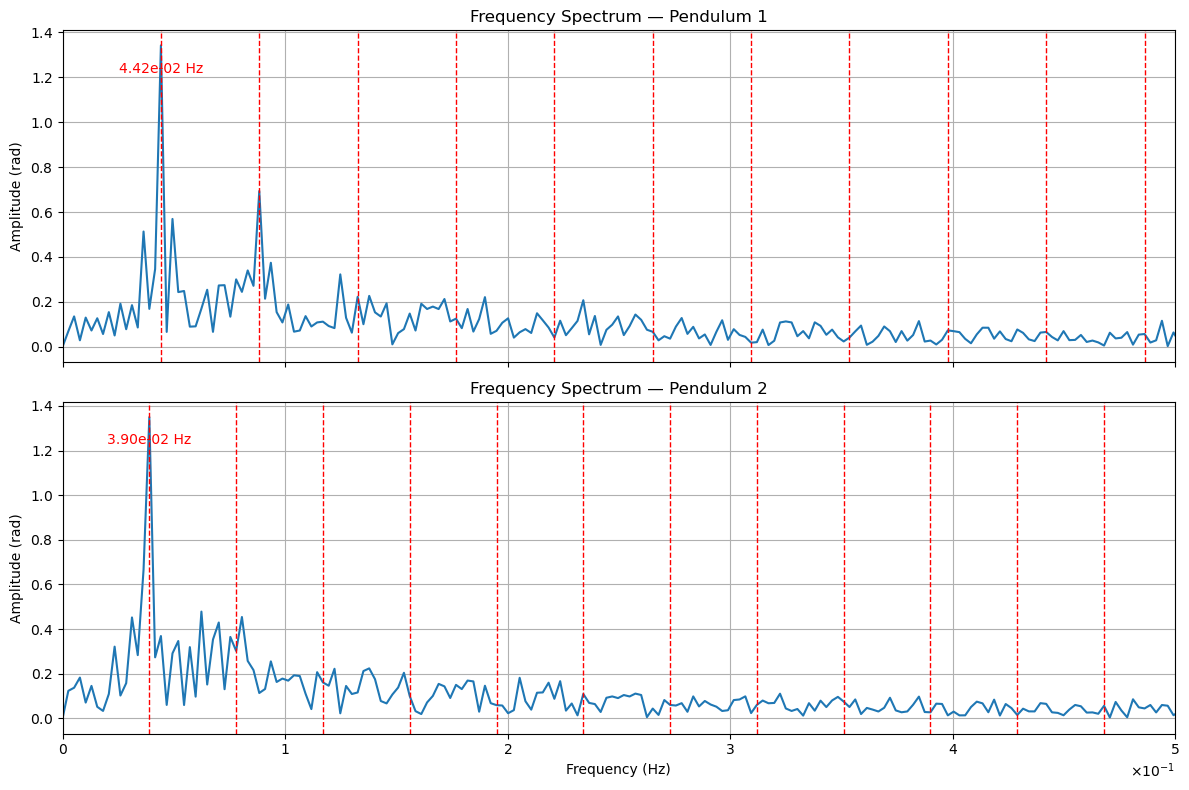

In [197]:


T = 1 / fps            
N = len(frames)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
for ax, (angle_data, label) in zip(
    [ax1, ax2],
    [(angles1, 'Pendulum 1'), (angles2, 'Pendulum 2')]
):
    y = angle_data - np.mean(angle_data) 

    # FFT
    Y = fft(y)
    freqs = fftfreq(N, T)[:N//2]          
    amps  = 2.0 / N * np.abs(Y[:N//2]) 

    # find fundamental
    pos = freqs > 0
    f0 = freqs[pos][np.argmax(amps[pos])] if np.any(pos) else 0.0

    # plot
    ax.plot(freqs, amps, lw=1.5)
    ax.set_title(f'Frequency Spectrum — {label}')
    ax.set_ylabel('Amplitude (rad)')
    ax.set_xlim(0, 0.5)       # up to Nyquist (fps/2 → 30Hz), adjust as needed
    ax.grid(True)

    # mark harmonics
    if f0 > 0:
        for n in range(1, int(freqs[-1] // f0) + 1):
            ax.axvline(n * f0, color='red', linestyle='--', linewidth=1)
        ax.text(
            f0, amps.max() * 0.9,
            f'{f0:.2e} Hz',
            color='red', ha='center', va='bottom'
        )

    # axes formatting
    ax.xaxis.set_major_formatter(sci_formatter)
    ax.yaxis.set_major_formatter(sci_formatter)

# common x-label
ax2.set_xlabel('Frequency (Hz)')

plt.tight_layout()
plt.show()


## Pendulum Tip Trajectories (y vs x)

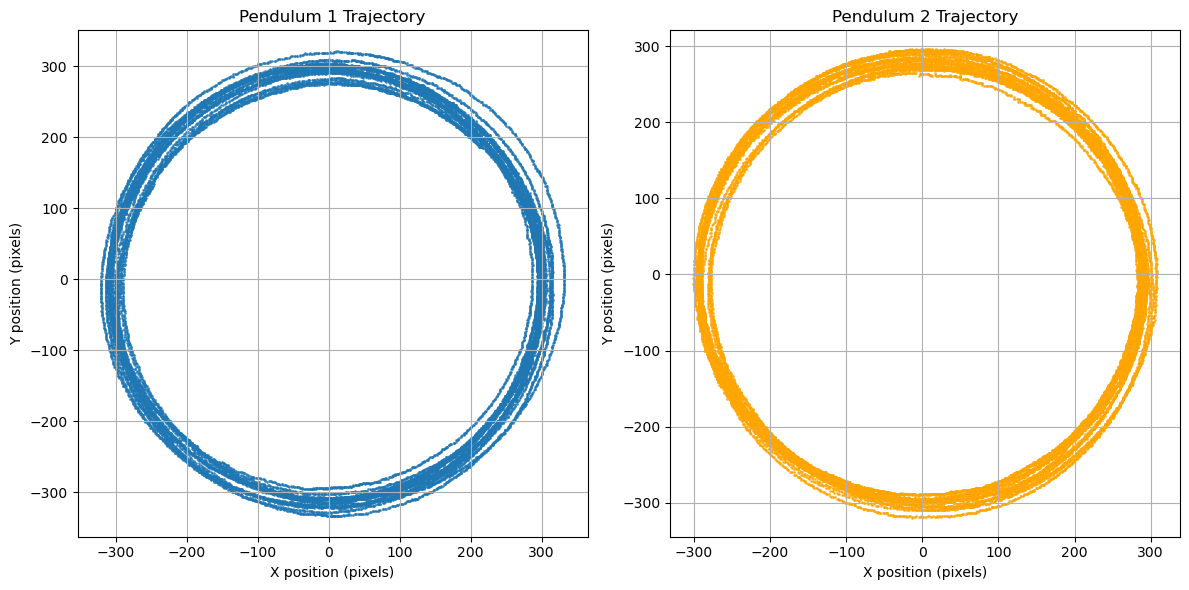

In [198]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Object 1 scatter trajectory
axs[0].scatter(x1 - c1[0], y1 - c1[1], s=1, alpha=0.7, label='Obj1')
axs[0].set_title('Pendulum 1 Trajectory')
axs[0].set_xlabel('X position (pixels)')
axs[0].set_ylabel('Y position (pixels)')
axs[0].axis('equal')
axs[0].grid(True)

# Object 2 scatter trajectory
axs[1].scatter(x2 - c2[0], y2 - c2[1], s=1, alpha=0.7, color='orange', label='Obj2')
axs[1].set_title('Pendulum 2 Trajectory')
axs[1].set_xlabel('X position (pixels)')
axs[1].set_ylabel('Y position (pixels)')
axs[1].axis('equal')
axs[1].grid(True)

plt.tight_layout()
plt.show()


## Phase Difference vs Time

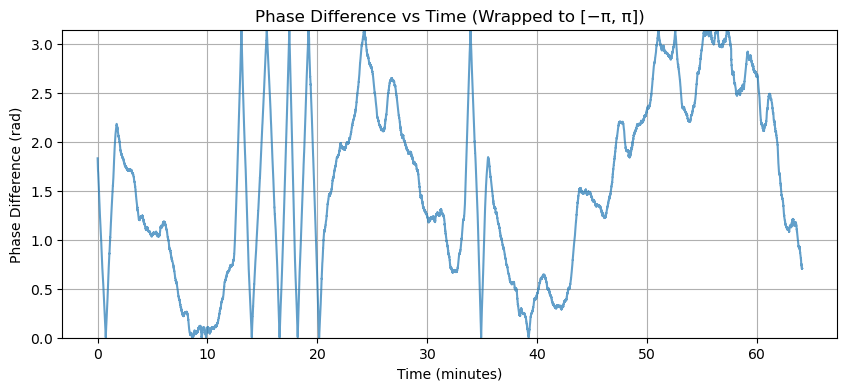

In [199]:
# raw difference
raw_diff = angles1 - angles2

# wrap into [-π, π]
phi_diff_wrapped = abs((raw_diff + np.pi) % (2 * np.pi) - np.pi)

# convert frames → minutes
time_min = frames / fps / 60  

plt.figure(figsize=(10, 4))
plt.plot(time_min, phi_diff_wrapped, '-', alpha=0.7)
plt.title('Phase Difference vs Time (Wrapped to [−π, π])')
plt.xlabel('Time (minutes)')
plt.ylabel('Phase Difference (rad)')
plt.ylim(0, np.pi)
plt.grid(True)

ax = plt.gca()
ax.xaxis.set_major_formatter(sci_formatter)
ax.yaxis.set_major_formatter(sci_formatter)

plt.show()

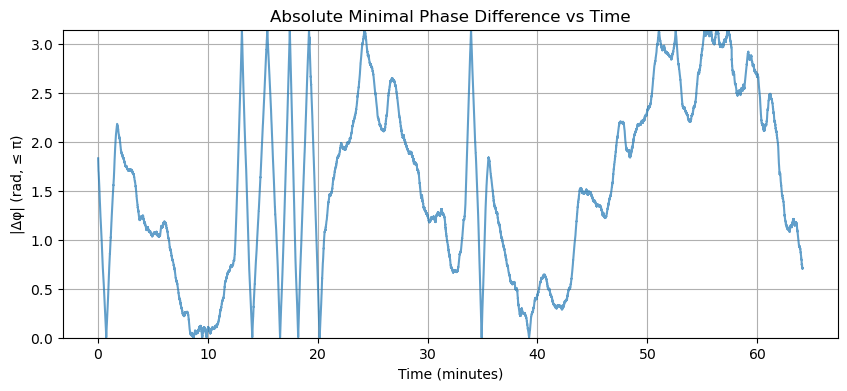

In [200]:
# Cell 11: Minimal & Absolute Phase Difference vs Time

# 1) principal-valued phase difference in (−π, π]
phi_diff = np.angle(np.exp(1j*(angles1 - angles2)))

# 2) magnitude of that difference in [0, π]
#phi_dist = np.abs(phi_diff)

# 3) time in minutes
time_min = frames / fps / 60

plt.figure(figsize=(10, 4))
plt.plot(time_min, phi_dist, '-', alpha=0.7)
plt.title('Absolute Minimal Phase Difference vs Time')
plt.xlabel('Time (minutes)')
plt.ylabel('|Δφ| (rad, ≤ π)')
plt.ylim(0, np.pi)
plt.grid(True)

ax = plt.gca()
ax.xaxis.set_major_formatter(sci_formatter)
ax.yaxis.set_major_formatter(sci_formatter)

plt.show()
